In [111]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
from torchvision.utils import save_image
import seaborn as sns
import matplotlib.pyplot as plt

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# VAE

### Encoder

In [112]:
class Encoder(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(Encoder, self).__init__()
        self.lin1 = nn.Linear(x_dim, h_dim1)
        self.lin2 = nn.Linear(h_dim1, h_dim2)
        self.lin31 = nn.Linear(h_dim2, z_dim) # mu
        self.lin32 = nn.Linear(h_dim2, z_dim) # log_var
        
    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        return self.lin31(x), self.lin32(x) # mu, log_var

### Decoder

In [113]:
class Decoder(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(Decoder, self).__init__()
        self.lin4 = nn.Linear(z_dim, h_dim2)
        self.lin5 = nn.Linear(h_dim2, h_dim1)
        self.lin6 = nn.Linear(h_dim1, x_dim)

    def forward(self, z):
        h = F.relu(self.lin4(z))
        h = F.relu(self.lin5(h))
        return torch.sigmoid(self.lin6(h)) 

### Model

In [114]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(x_dim, h_dim1, h_dim2, z_dim)
        self.decoder = Decoder(x_dim, h_dim1, h_dim2, z_dim)
        
    def sampling(self, mu, log_var): 
        std = torch.sqrt(torch.exp(log_var))
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, log_var = self.encoder.forward(x)
        z = self.sampling(mu, log_var)
        mu_d = self.decoder(z)
        return mu_d, mu, log_var
    
    def generate(self, z):
        return self.decoder(z)

# Loss

In [115]:
def kl_mvn(mu, sigma, device):
    N = mu.shape[1]
    mu = mu.reshape(mu.shape[0], mu.shape[1], 1)
    tr_term   = torch.sum(sigma, axis = 1)
    det_term  = -torch.log(torch.prod(sigma, axis = 1))
    quad_term = torch.transpose(mu, 1, 2) @ mu
    return torch.sum(0.5 * (tr_term + det_term + quad_term - N))

In [116]:
def loss_function(recon_x, x, mu, log_var, beta):
    BCE =  F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = kl_mvn(mu, torch.exp(log_var), device)
    return BCE + beta * KLD

# Train and test functions

In [124]:
def test(vae, test_loader, beta):
    vae.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(test_loader):
            data = data.reshape([-1, 784])
            recon, mu, log_var = vae(data)
            test_loss += loss_function(recon, data, mu, log_var, beta).item()
        
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss}')
    return test_loss

In [125]:
def train(vae, epoch, optimizer, train_loader, beta):
    vae.train()
    train_loss = 0
    batch_idx = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        data = data.reshape([-1, 784])
        optimizer.zero_grad()
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var, beta)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        batch_idx += 1
    train_loss /= len(train_loader.dataset)
    print(f'====> Epoch: {epoch} Average loss: {train_loss}')
    return train_loss

# Train and test sets

In [126]:
# Batch size
bs = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)
test_dataset = datasets.MNIST(root='./mnist_data/',
                              train=False,
                              transform=transforms.ToTensor(),
                              download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

# Training

In [ ]:
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
vae = vae.to(device)
optimizer = optim.Adam(vae.parameters())

train_losses = []
test_losses = []
for epoch in range(1, 51):
    train_loss = train(vae, epoch, optimizer, train_loader, 0.1)
    train_losses.append(train_loss)
    vae = vae.cpu() # weird stuff happens when model is on GPU during testing
    test_loss = test(vae, test_loader, 0.1)
    test_losses.append(test_loss)
    vae = vae.to(device)

====> Epoch: 1 Average loss: 177.63921728515626
====> Test set loss: 167.04786755371094
====> Epoch: 2 Average loss: 165.19479329427082
====> Test set loss: 163.36739477539064
====> Epoch: 3 Average loss: 162.11614813639324
====> Test set loss: 161.2070421142578
====> Epoch: 4 Average loss: 160.37610712890626
====> Test set loss: 159.72736186523437


TypeError: 'NoneType' object is not iterable

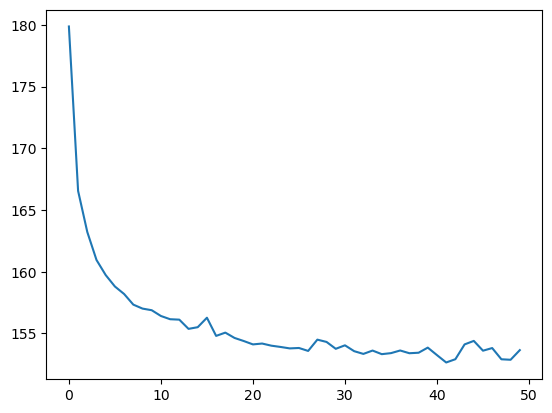

In [121]:
sns.lineplot(data=train_losses)
sns.lineplot(data=test_losses)
plt.legend(labels=['train_loss', 'test_loss'])
plt.xlabel('Loss')
plt.ylabel('Epoch')

In [122]:
print(test_losses)
print(train_losses)

[tensor(170.2381), tensor(164.8555), tensor(162.0847), tensor(160.8446), tensor(159.9016), tensor(159.1483), tensor(157.3567), tensor(157.9079), tensor(157.7563), tensor(156.5211), tensor(157.2785), tensor(157.0353), tensor(156.4331), tensor(155.3626), tensor(157.7559), tensor(155.8699), tensor(155.0143), tensor(154.8925), tensor(155.1117), tensor(155.0805), tensor(154.8062), tensor(155.6361), tensor(154.2713), tensor(154.4934), tensor(154.5265), tensor(154.6238), tensor(155.9459), tensor(156.3406), tensor(154.7824), tensor(154.3289), tensor(154.4541), tensor(154.1154), tensor(155.9353), tensor(154.1305), tensor(154.9451), tensor(155.5164), tensor(155.1859), tensor(154.1348), tensor(154.3222), tensor(154.2019), tensor(153.9871), tensor(154.0758), tensor(156.6090), tensor(155.6253), tensor(154.8797), tensor(155.0502), tensor(153.4986), tensor(154.7456), tensor(155.3341), tensor(154.3283)]
[179.876437890625, 166.55146145833334, 163.21837059733073, 160.9530272745768, 159.72890345865886, 1

In [22]:
with torch.no_grad():
    z = torch.randn(64, 2).to(device)
    sample = vae.generate(z).cpu()
    save_image(sample.view(64, 1, 28, 28), './samples/sample' + '.png')